In [1]:
import pandas as pd
import requests

# Gathering Subreddit #1: Capitalism

Collecting data from the Capitalism subreddit and exporting as a csv:

In [2]:
# base_url = 'https://api.pushshift.io/reddit/search/submission/?'
# before_utc = 1580408341
# params = {
#     'subreddit' : 'capitalism',
#     'is_video' : 'false',
#     'size' : 1000,
#     'before': before_utc, # before 12:19 pm on 01/30/2020
#     'sort' : 'desc'
# }
# results_cap = requests.get(base_url, params)

# results_cap

# cap_dict = results_cap.json()

# cap_dict['data'];

# len(cap_dict['data'])

# cap = pd.DataFrame(cap_dict['data']);

# cap.to_csv('./cap.csv')

# Gathering Subreddit #2: Democratic Socialism

Collecting data from the DemocraticSocialism subreddit and exporting as a csv:

In [3]:
# base_url = 'https://api.pushshift.io/reddit/search/submission/?'
# before_utc = 1580408341
# params = {
#     'subreddit' : 'democraticsocialism',
#     'is_video' : 'false',
#     'size' : 1000,
#     'before': before_utc, # before 12:19 pm on 01/30/2020
#     'sort' : 'desc'
# }
# results_ds = requests.get(base_url, params)

# results_ds

# ds_dict = results_ds.json()

# ds_dict['data'];

# len(ds_dict['data'])

# ds = pd.DataFrame(ds_dict['data']);

# ds.to_csv('./ds.csv')

# Cleaning/Preparing Dataframes

**CAPITALISM DF:**

In [4]:
pd.set_option('max_columns', 99)
pd.set_option('max_rows', 99)

In [5]:
cap = pd.read_csv('./cap.csv')

# Check for NaNs
print(cap[['title']].isnull().sum())
print(cap[['selftext']].isnull().sum())

# Replacing NaNs with nothing
cap['selftext'].fillna('', inplace=True)
print(cap['selftext'].isnull().sum())

# merging TITLE and SELFTEXT columns into one:
cap['text'] = cap['title'] + " " + cap['selftext']
print(cap['text'].isnull().sum())
print(cap['text'].dtypes)

# lower-casing the word "Capitalism" in the subreddit column
cap[['subreddit']] = 'capitalism'
cap[['subreddit']];

# overwriting the df variable with only my necessary two columns:
cap = cap[['text', 'subreddit']]
cap;

title    0
dtype: int64
selftext    741
dtype: int64
0
0
object


**DEMOCRATIC SOCIALISM DF:**

In [6]:
ds = pd.read_csv('./ds.csv')

# Check for NaNs
print(ds[['title']].isnull().sum())
print(ds[['selftext']].isnull().sum())

# Replacing NaNs with nothing
ds['selftext'].fillna('', inplace=True)
print(ds['selftext'].isnull().sum())

# merging TITLE and SELFTEXT columns into one:
ds['text'] = ds['title'] + " " + ds['selftext']
print(ds['text'].isnull().sum())
print(ds['text'].dtypes)

# lower-casing the "DemocraticSocialism" in the subreddit column
ds[['subreddit']] = 'democraticsocialism'
ds[['subreddit']];

# overwriting the df variable with only my necessary two columns:
ds = ds[['text', 'subreddit']]
ds;

title    0
dtype: int64
selftext    884
dtype: int64
0
0
object


**CONCATENATE BOTH DF'S:**

In [7]:
df = pd.concat([cap, ds], ignore_index = 'True')
df.tail();

**Taking away the words '[deleted]' and '[removed]' from threads where the user or Reddit deleted/removed content**

In [8]:
sub = '[deleted]'
deleted = df["text"].str.find(sub)
deleted = pd.DataFrame(deleted)
deleted = deleted.loc[deleted['text'] > 0]
deleted = deleted.reset_index()

del_list = []
for item in deleted['index']:
    del_list.append(item)
del_list;

for num in del_list:
    df['text'][num] = df['text'][num].replace('[deleted]', '', True)

In [9]:
sub = '[removed]'
removed = df["text"].str.find(sub)
removed = pd.DataFrame(removed)
removed = removed.loc[removed['text'] > 0]
removed = removed.reset_index()

rem_list = []
for item in removed['index']:
    rem_list.append(item)
rem_list;

for num in rem_list:
    df['text'][num] = df['text'][num].replace('[removed]', '', True)

# NLP PRE-PROCESSING:

In [10]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
import regex as re
# from nltk.stem import WordNetLemmatizer
# from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
# Create train_test_split.

X = df[['text']]
y = df[['subreddit']]

X_train,\
X_test,\
y_train,\
y_test = train_test_split(X, y, test_size = 0.33,\
                          stratify = y, random_state = 42)

**Create a function for the NLP cleaning**:

In [12]:
def nlp_cleaning(data):
    
    data1 = BeautifulSoup(data).get_text()
    data1_letters_only = re.sub("[^a-zA-Z]", " ", data1)
    data2 = data1_letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in data2 if w not in stops]
    
    return(" ".join(meaningful_words))

In [13]:
print(X_train['text'][0])
print()
print('vs')
print()
print(nlp_cleaning(X_train['text'][0]))

World War I: country-by-country count of human losses (in true scale) 

vs

world war country country count human losses true scale


In [14]:
X_train_words = []
X_test_words = []

print("Cleaning and parsing the training set..")

j = 0

for row in X_train['text']:
    
    X_train_words.append(nlp_cleaning(row))
    if (j + 1) % 100 == 0:
        print(f'Thread {j + 1} of {X_train.shape[0]}.')
    j += 1
    if (j + 1) / 1340 == 1:
        print(f'Thread {j + 1} of {X_train.shape[0]}.')
    
    
# Same for the testing set...
print("Cleaning and parsing the testing set...")

# Re-instantiate counter.
j = 0

for row in X_test['text']:
    
    X_test_words.append(nlp_cleaning(row))
    if (j + 1) % 100 == 0:
        print(f'Thread {j + 1} of {X_test.shape[0]}.')    
    j += 1
    if (j + 1) / 660 == 1:
        print(f'Thread {j + 1} of {X_test.shape[0]}.')

Cleaning and parsing the training set..
Thread 100 of 1340.
Thread 200 of 1340.
Thread 300 of 1340.
Thread 400 of 1340.
Thread 500 of 1340.
Thread 600 of 1340.
Thread 700 of 1340.
Thread 800 of 1340.
Thread 900 of 1340.
Thread 1000 of 1340.
Thread 1100 of 1340.
Thread 1200 of 1340.
Thread 1300 of 1340.
Thread 1340 of 1340.
Cleaning and parsing the testing set...
Thread 100 of 660.
Thread 200 of 660.
Thread 300 of 660.
Thread 400 of 660.
Thread 500 of 660.
Thread 600 of 660.
Thread 660 of 660.


In [15]:
X_train_words;

**Let's say up a Count Vectorizer manually:**

In [16]:
stops = set(stopwords.words('english'))

In [17]:
cvec = CountVectorizer(stop_words = stops)

X_train_words_cvec = cvec.fit_transform(X_train_words)

X_test_words_cvec = cvec.transform(X_test_words)

print(X_train_words_cvec.shape)
print(X_test_words_cvec.shape)

vocab = cvec.get_feature_names()

pd.DataFrame(X_train_words_cvec.toarray(), columns = vocab);

(1340, 6471)
(660, 6471)


**Let's also set up a Tfidf Vectorizer manually**:

In [18]:
tfidf = TfidfVectorizer(stop_words = stops)

X_train_words_tfidf = tfidf.fit_transform(X_train_words)

X_test_words_tfidf = tfidf.transform(X_test_words)

print(X_train_words_tfidf.shape)
print(X_test_words_tfidf.shape)

vocab = tfidf.get_feature_names()

pd.DataFrame(X_train_words_cvec.toarray(), columns = vocab);

(1340, 6471)
(660, 6471)


# MODELING

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import wordcloud
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import confusion_matrix

%matplotlib inline

**Logistic Regression on CountVectorized data:**

In [21]:
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_cvec_lr_params = {
    'cvec__max_features': [100,200,500,1000,2000],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ('l1', 'l2')
}

gs_cvec_lr = GridSearchCV(pipe_cvec_lr,                    
                  param_grid=pipe_cvec_lr_params, 
                  cv=5) # 5-fold cross-validation.

gs_cvec_lr.fit(X_train_words, y_train);

gs_cvec_lr.score(X_test_words, y_test)

0.7863636363636364

In [22]:
lr = LogisticRegression()

In [23]:
X_train_words_df = pd.DataFrame(X_train_words_cvec.toarray(), columns = cvec.get_feature_names())
X_test_words_df = pd.DataFrame(X_test_words_cvec.toarray(), columns = cvec.get_feature_names())

lr.fit(X_train_words_df, y_train)
print(f'Logistic Regression on CounterVectorizer Score: {lr.score(X_test_words_df, y_test)}')
preds = lr.predict(X_test_words_df)
cols = 'Preds: ' + lr.classes_
rows = 'Actual: ' + lr.classes_ 

pd.DataFrame(confusion_matrix(y_test, preds), columns=cols, index=rows)

Logistic Regression on CounterVectorizer Score: 0.7833333333333333


,Preds: capitalism,Preds: democraticsocialism
Actual: capitalism,257,73
Actual: democraticsocialism,70,260


^ Correctly predicted about 78% of both sets of words

**Logistic Regression on TfidfVectorized data:**

In [24]:
pipe_tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_tfidf_lr_params = {
    'tfidf__stop_words' : [None, 'english'],
}  # originally I had a bunch of other parameters here, but for some reason
    # my score actually increased when I got rid of all of them.

gs_tfidf_lr = GridSearchCV(pipe_tfidf_lr,                    
                  param_grid=pipe_tfidf_lr_params, 
                  cv=5) # 5-fold cross-validation.

gs_tfidf_lr.fit(X_train_words, y_train);

gs_tfidf_lr.score(X_test_words, y_test)

0.7833333333333333

In [25]:
X_train_words_df_tfidf = pd.DataFrame(X_train_words_tfidf.toarray(), columns = tfidf.get_feature_names())
X_test_words_df_tfidf = pd.DataFrame(X_test_words_tfidf.toarray(), columns = tfidf.get_feature_names())

lr.fit(X_train_words_df_tfidf, y_train)
print(f'Logistic Regression on TfidfVectorizer Score: {lr.score(X_test_words_df_tfidf, y_test)}')
preds = lr.predict(X_test_words_df_tfidf)
cols = 'Preds: ' + lr.classes_
rows = 'Actual: ' + lr.classes_ 

pd.DataFrame(confusion_matrix(y_test, preds), columns=cols, index=rows)

Logistic Regression on TfidfVectorizer Score: 0.7757575757575758


,Preds: capitalism,Preds: democraticsocialism
Actual: capitalism,274,56
Actual: democraticsocialism,92,238


^ Correctly predicted about 77.6% of both sets of words

Highest accuracy score from pipeline using Logistic Regression + Count Vectorizer was:

78.63%

Highest accuracy score from pipeline using Logistic Regression + TfidfVectorizer was:

78.33%

**Multinomial NB on CountVectorized data:**

In [26]:
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_cvec_mnb_params = {
    'cvec__max_features': [100,200,500,1000,2000],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
}

gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb,                    
                  param_grid=pipe_cvec_mnb_params, 
                  cv=5)

gs_cvec_mnb.fit(X_train_words, y_train);

gs_cvec_mnb.score(X_test_words, y_test)

0.7696969696969697

Accuracy Score of 76.97%

**Multinomial NB on TfidfVectorized data:**

In [27]:
pipe_tfidf_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

pipe_tfidf_mnb_params = {
    'tfidf__max_features': [None, 100,200,500,1000,2000],
    'tfidf__stop_words' : [None, 'english'],
    'tfidf__ngram_range': [(1,1), (1,2)],
}

gs_tfidf_mnb = GridSearchCV(pipe_tfidf_mnb,                    
                  param_grid=pipe_tfidf_mnb_params, 
                  cv=5)

gs_tfidf_mnb.fit(X_train_words, y_train);

gs_tfidf_mnb.score(X_test_words, y_test)

0.7818181818181819

Highest accuracy score from pipeline using MultinomialNB + CountVectorizer was:

76.97%

Highest accuracy score from pipeline using MultinomialNB + TfidfVectorizer was:

78.18%

**SupportVectorMachine on CountVectorizer data:**

In [28]:
svc = SVC(gamma='scale')
svc_cvec = svc.fit(X_train_words_cvec, y_train)
svc_cvec.score(X_train_words_cvec, y_train)

0.9201492537313433

**SupportVectorMachine on TfidfVectorizer data:**

In [29]:
svc_tfidf = svc.fit(X_train_words_tfidf, y_train)
svc_tfidf.score(X_train_words_tfidf, y_train)

0.985820895522388

Highest accuracy score from pipeline using Support Vector Machines + CountVectorizer was:

92.01%

Highest accuracy score from pipeline using Support Vector Machines + TfidfVectorizer was:

98.58%

In [30]:
cap_words = []
for row in cap['text']:
    cap_words.append(nlp_cleaning(row))

In [31]:
tokenizer = RegexpTokenizer(r'\w+')
item
for item in cap_words:
    item_tokens = tokenizer.tokenize(item)
item_tokens

['pro', 'tips', 'pitching', 'products', 'banks', 'credit', 'unions']

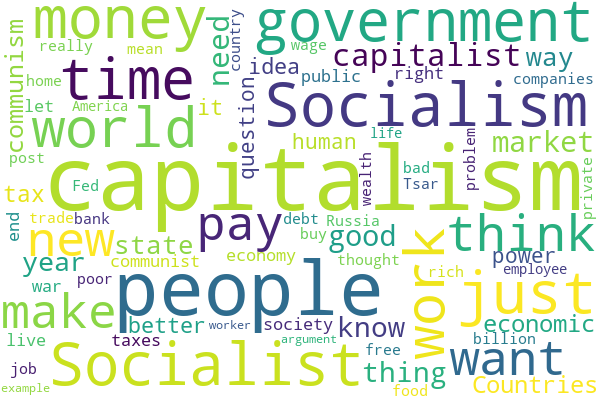

In [32]:
stops2 = list(ENGLISH_STOP_WORDS) + ['http', 'say', 'it', 'going', 'www', "I'm", 'com', 'does', 'https', 'amp', 'it', "don't", 'like']
wc = wordcloud.WordCloud(width=600, height=400, max_words=75, stopwords=stops2, background_color='white')
cap_text = df.loc[df['subreddit'] == 'capitalism', 'text'].str.cat()
wc.generate_from_text(cap_text)
wc.to_image()

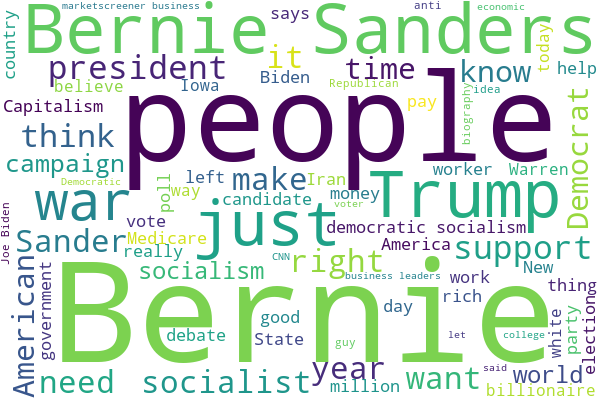

In [33]:
wc = wordcloud.WordCloud(width=600, height=400, max_words=75, stopwords=stops2, background_color='white')
ds_text = df.loc[df['subreddit'] == 'democraticsocialism', 'text'].str.cat()
wc.generate_from_text(ds_text)
wc.to_image()

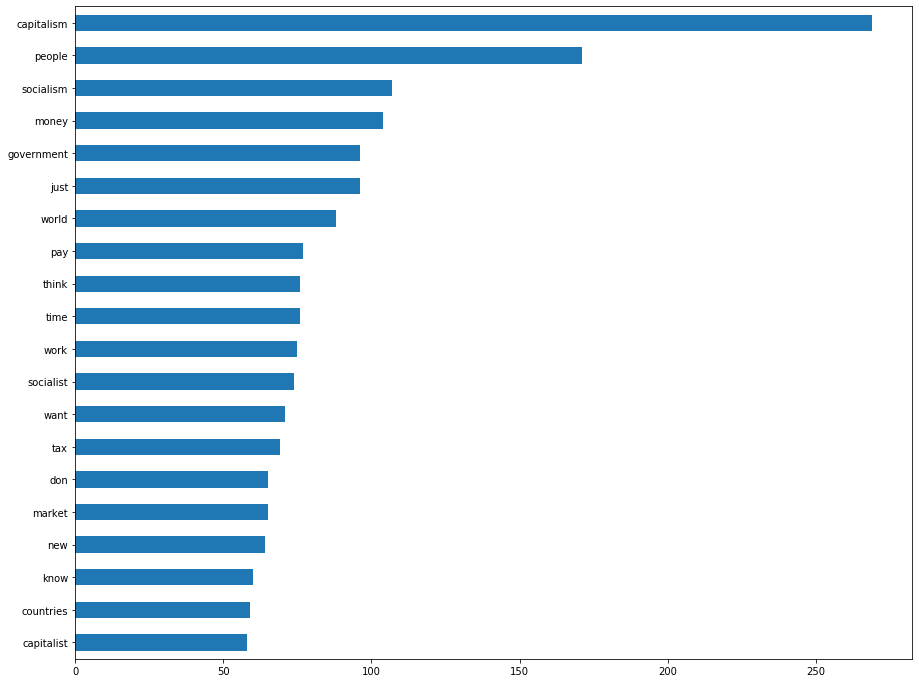

In [34]:
fig , ax = plt.subplots(figsize=(15,12))

cvec2 = CountVectorizer(stop_words=stops2, min_df=6, ngram_range=(1,1))

cap_df_2 = pd.DataFrame(cvec2.fit_transform(cap['text']).todense(), columns= \
                      cvec2.get_feature_names())

cap_df_2.sum().sort_values().tail(20).plot.barh()

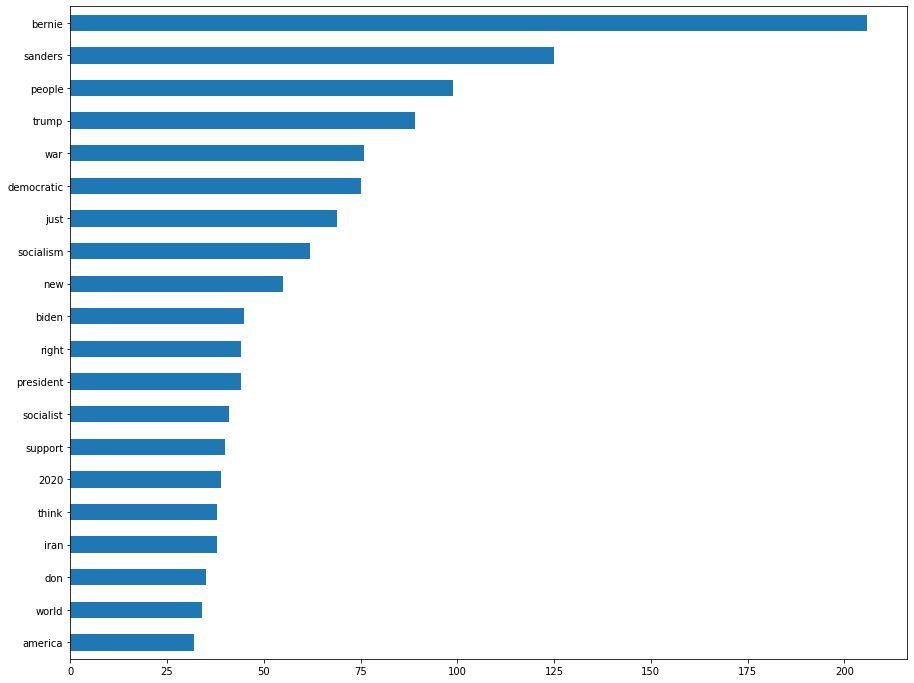

In [35]:
fig , ax = plt.subplots(figsize=(15,12))

ds_df_2 = pd.DataFrame(cvec2.fit_transform(ds['text']).todense(), columns= \
                      cvec2.get_feature_names())

ds_df_2.sum().sort_values().tail(20).plot.barh()

ax.yaxis.label.set_size(30)

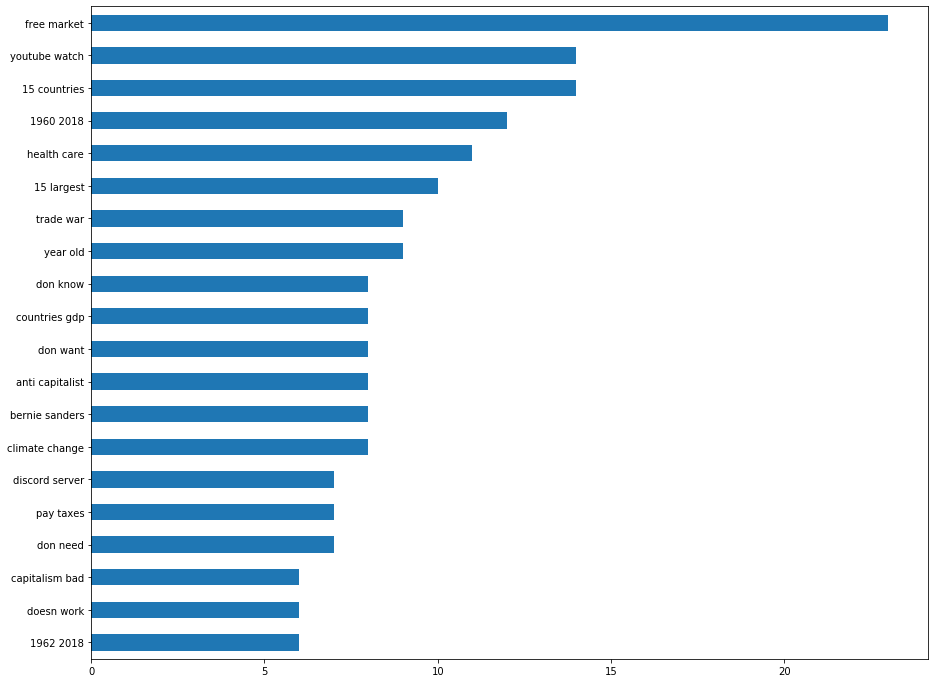

In [36]:
fig , ax = plt.subplots(figsize=(15,12))

cvec3 = CountVectorizer(stop_words=stops2, min_df=6, ngram_range=(2,2))

cap_df_2 = pd.DataFrame(cvec3.fit_transform(cap['text']).todense(), columns= \
                      cvec3.get_feature_names())

cap_df_2.sum().sort_values().tail(20).plot.barh()

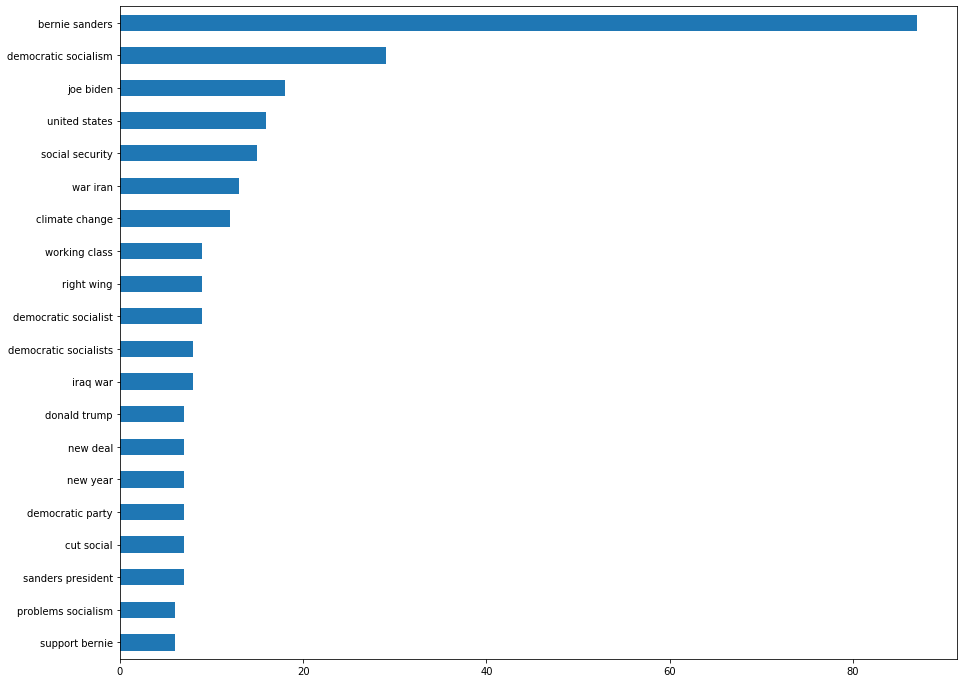

In [37]:
fig , ax = plt.subplots(figsize=(15,12))

ds_df_2 = pd.DataFrame(cvec3.fit_transform(ds['text']).todense(), columns= \
                      cvec3.get_feature_names())

ds_df_2.sum().sort_values().tail(20).plot.barh()

ax.yaxis.label.set_size(30)

# Conclusion

Although some of the word results in these models seem like they would be more intuitive (e.g. "free market" and "money" in capitalism or "bernie" in democratic socialism), there are others like "climate change," "bernie sanders," "people," and "socialism" that make the top 20 in both subreddits. Some recommendations I would make for further analysis would be to separate the data into yearly segments, do a sentiment analysis, and look for overlap in authors to see if a small group of people are active on both subreddits.

Both of these subreddits are less than a decade old, and needless to say, politics has changed dramatically in that time. It could prove insightful to run models and analyses on each subreddit's threads for each calendar year they've existed. For example, looking at how something like sentiment analysis changes from year to year might reveal something significant about the subreddit origin of the words. A hypothesis for that specific analysis might be that, since the beginning of the threads' existence, the word "capitalism" has slowly become viewed more unfavorably each year (and the opposite for the term "democratic socialism"). It would be interesting to see if that societal trend is paralleled in these subreddits. If the hypothesis proves false, it could suggest that the culture in these particular subreddits is more unique to its individual authors (a small portion of the population that is active on Reddit) and not reflective of societal cultural in a broader sense.